In [470]:
import numpy as np
import unittest
import matplotlib.pyplot as plt

## 조건
- Function 클래스는 기반 클래스로서, 모든 함수에 공통되는 기능을 구현한다.
- 구체적인 함수는 Function 클래스를 상속한 클래스에서 구현된다.

In [471]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [472]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError("{}은(는) 지원하지 않습니다".format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
    
#     def backward(self):
#         """ 재귀 """
#         f = self.creator
#         if f is not None:
#             x = f.input
#             x.grad = f.backward(self.grad)
#             x.backward()
    
    def backward(self):
        """ 반복문 """
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        
        while funcs:
            f = funcs.pop()
            
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
            
            for x, gx in zip(f.inputs, gxs):
                x.grad = gx
                
                if x.creator is not None:
                    funcs.append(x.creator)


In [473]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, gy):
        raise NotImplementedError()

In [474]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

In [475]:
class Exp(Function):
    def forward(self, x):
        return np.exp(x)

# 수치미분

In [476]:
def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(as_array(x.data-eps))
    x1 = Variable(as_array(x.data+eps))
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)

# 합성함수 미분

In [477]:
def f(x):
    f1 = Square()
    f2 = Exp()
    f3 = Square()
    return f3(f2(f1(x)))

In [478]:
def simulate_func_and_diff(func, test_range=(-1,1), test_size=100, figsize=(5,3)):
    fig = plt.figure(figsize=figsize)
    x = Variable(np.linspace(*test_range, num=test_size))
    plt.scatter(x.data, func(x).data, s=1, label="f(x)")
    plt.scatter(x.data, numerical_diff(func, x), s=1, label="f`(x)")
    plt.legend()
    plt.show()

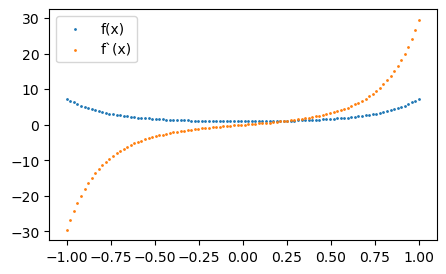

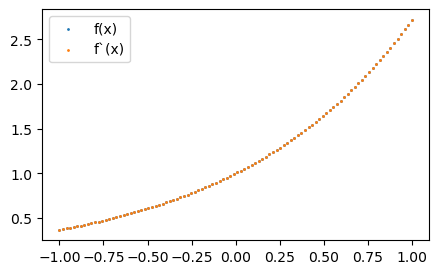

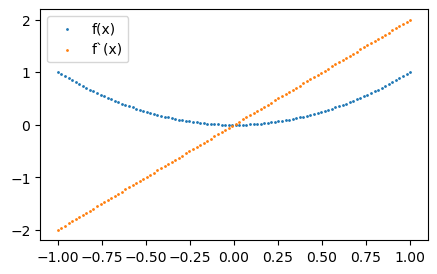

In [479]:
simulate_func_and_diff(f)
simulate_func_and_diff(Exp())
simulate_func_and_diff(Square())

# 수동 역전파

In [480]:
class Square(Function):
    def forward(self, x):
        y = x**2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [481]:
def square(x): return Square()(x)
def exp(x): return Exp()(x)

In [482]:
class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

In [483]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    def backward(self, gy):
        return gy, gy

def add(x0, x1) : return Add()(x0, x1)

In [484]:
y = add(Variable(np.array(1.0)), Variable(np.array(4.8)))
print(y.data)

5.8


In [485]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()

print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


In [486]:
x = Variable(np.linspace(-10,10,100))
y = Variable(np.linspace(-10,10,100))
z = add(square(x), square(y))
z.backward()

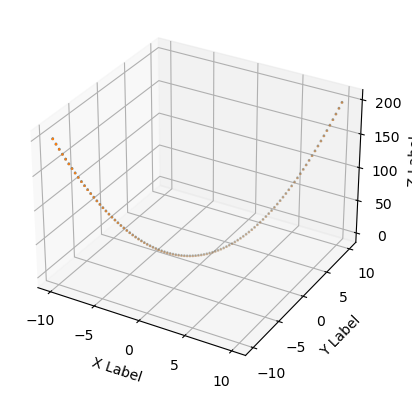

In [487]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = x.data
    ys = y.data
    zs = z.data
    ax.scatter(xs, ys, zs, marker=m, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()